# 2026.01.05 DSM->訓練$\epsilon_{\theta}$
# 一維雙峰

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

sigma_dsm=1.3
batch_size=2048


In [7]:
def sample_noisy_x(batch_size, x_dim, sigma):
    mu1 = np.array([-2] + [0]*(x_dim-1), dtype=np.float32)
    mu2 = np.array([ 2] + [0]*(x_dim-1), dtype=np.float32)

    w = np.random.rand(batch_size) < 0.5
    x = np.zeros((batch_size, x_dim), dtype=np.float32)

    x[w]  = mu1 + np.random.randn(w.sum(),  x_dim).astype(np.float32)
    x[~w] = mu2 + np.random.randn((~w).sum(), x_dim).astype(np.float32)

    eps = np.random.randn(batch_size, x_dim).astype(np.float32)
    x_tilde = x + sigma * eps

    return x_tilde, eps


In [8]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)


def dsm_loss_step(x_dim, sampler):
    x_tilde_np, eps_np = sampler(batch_size, x_dim, sigma_dsm)
    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    eps_pred = model(x_tilde)  ###<<<<< 預測epsilon

    target = eps
    loss = ((eps_pred - target)**2).mean()
    return loss



In [9]:
model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)

#### Training Loop
num_steps=5000
lr=5e-3

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step(1, sample_noisy_x)
    

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


step  200 | loss = 0.646510 | lr = 0.005000
step  400 | loss = 0.656402 | lr = 0.005000
step  600 | loss = 0.676319 | lr = 0.005000
step  800 | loss = 0.706736 | lr = 0.005000
step 1000 | loss = 0.695274 | lr = 0.005000
step 1200 | loss = 0.735624 | lr = 0.005000
step 1400 | loss = 0.664884 | lr = 0.005000
step 1600 | loss = 0.690761 | lr = 0.005000
step 1800 | loss = 0.665939 | lr = 0.005000
step 2000 | loss = 0.659823 | lr = 0.005000
step 2200 | loss = 0.647487 | lr = 0.005000
step 2400 | loss = 0.654713 | lr = 0.005000
step 2600 | loss = 0.731261 | lr = 0.005000
step 2800 | loss = 0.637241 | lr = 0.005000
step 3000 | loss = 0.638413 | lr = 0.005000
step 3200 | loss = 0.672237 | lr = 0.005000
step 3400 | loss = 0.697648 | lr = 0.005000
step 3600 | loss = 0.649403 | lr = 0.005000
step 3800 | loss = 0.682021 | lr = 0.005000
step 4000 | loss = 0.666920 | lr = 0.005000
step 4200 | loss = 0.701493 | lr = 0.005000
step 4400 | loss = 0.715902 | lr = 0.005000
step 4600 | loss = 0.675045 | lr

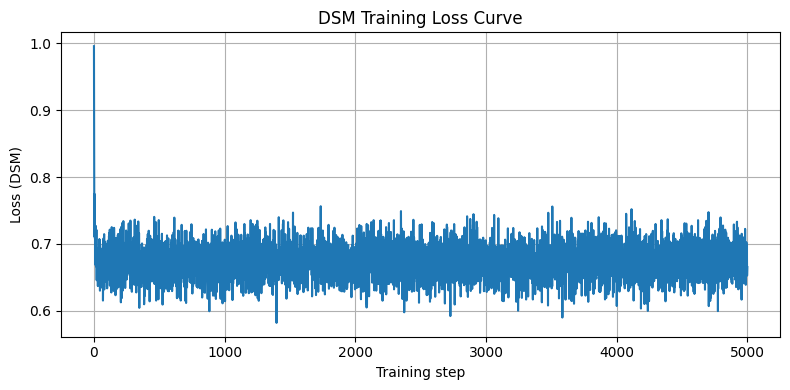

In [10]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

# 一維雙峰Sampling